<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

## Data Extraction

In [ ]:
import numpy as np
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Generate a sine wave for demonstration

In [ ]:
from tqdm.autonotebook import tqdm
from statsforecast import StatsForecast

from statsforecast.utils import AirPassengersDF, ConformalIntervals
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [ ]:
cycles = 26
weeks = cycles * 2
resolution = 7


np.random.seed(0)
t = np.linspace(0, 
                cycles * np.pi,
                weeks * resolution)

waveform = np.random.normal(scale=0.5, size=len(t)) + 0.5 * np.sign(np.sin(0.67 * t))
sine_wave = np.sin(t) + 0.3*np.sin(4.71*t) + waveform

In [ ]:
# Create a Pandas DataFrame
df = pd.DataFrame({'y': sine_wave})
df['unique_id'] = 1

In [ ]:
rng = pd.date_range('04/01/2021', periods=df.shape[0], freq='D')
df['ds'] = rng
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   y          364 non-null    float64       
 1   unique_id  364 non-null    int64         
 2   ds         364 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 8.7 KB


In [ ]:
df_plot = df.copy()
df_plot.rename(columns={'y': 'final'}, inplace=True)
df_plot['unique_id'] = 'final'
df_plot['first'] = np.sin(t)
df_plot['second'] = 0.3*np.sin(5*t)
df_plot['noise'] = np.random.normal(scale=0.2, size=len(t))
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   final      364 non-null    float64       
 1   unique_id  364 non-null    object        
 2   ds         364 non-null    datetime64[ns]
 3   first      364 non-null    float64       
 4   second     364 non-null    float64       
 5   noise      364 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 17.2+ KB


In [ ]:
import altair as alt

def long_form(df_plot):
    return df_plot.melt('ds', var_name='unique_id', value_name='price')

def altair_plot(df_plot): 
    highlight = alt.selection_point(on='mouseover', fields=['unique_id'], nearest=True)

    base = alt.Chart(df_plot).encode(
        x='ds:T',
        y='price:Q',
        color='unique_id:N'
    )

    points = base.mark_circle().encode(
        opacity=alt.value(0)
    ).add_params(
        highlight
    ).properties(
        width=1000
    )

    lines = base.mark_line().encode(
        size=alt.condition(~highlight, alt.value(1), alt.value(3))
    )

    return points + lines

df_plot = long_form(df_plot)
altair_plot(df_plot)

alt.LayerChart(...)

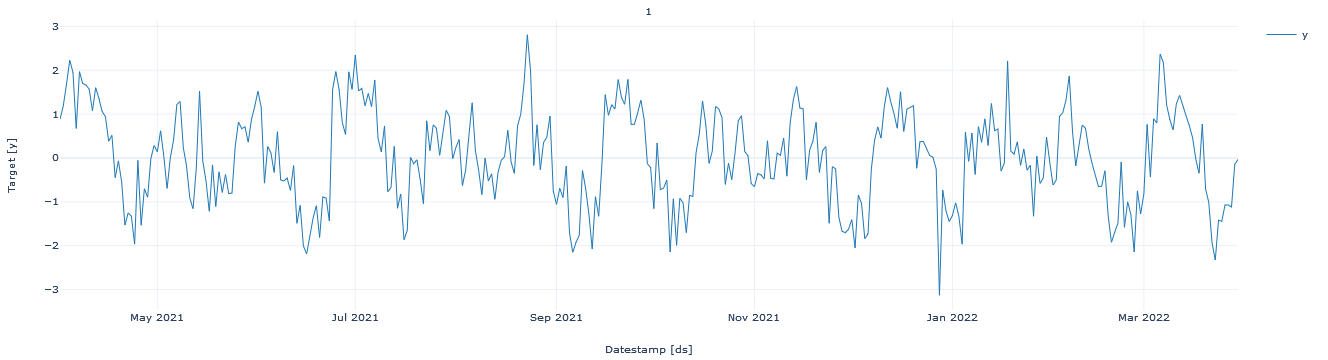

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = (15,4)
StatsForecast.plot(df, engine='plotly')

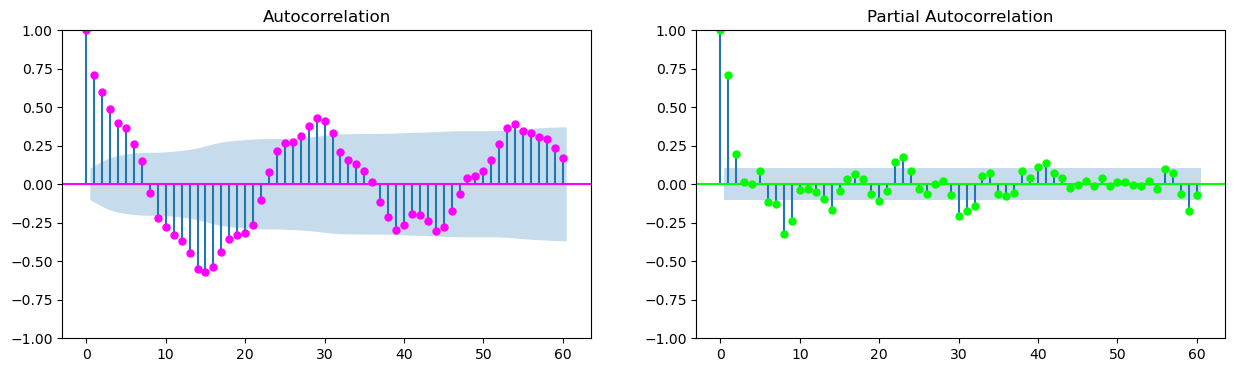

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=60, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(df["y"],  lags=60, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

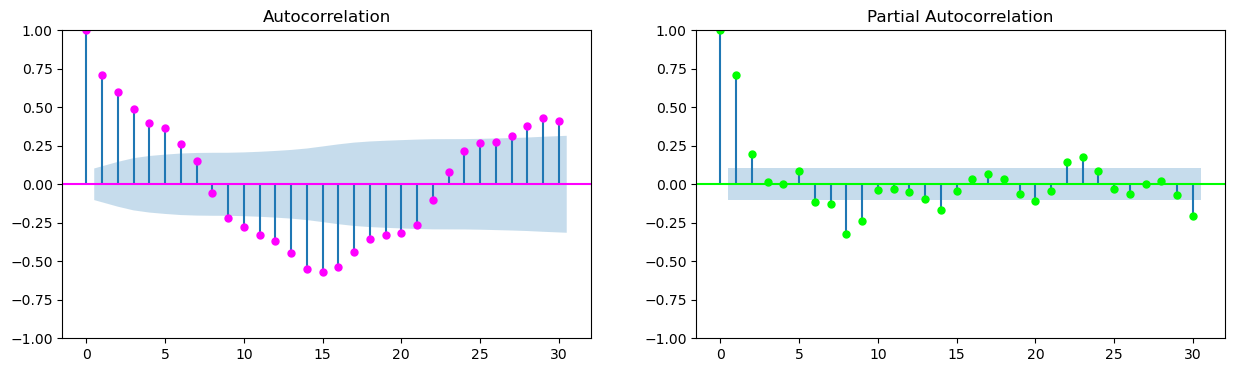

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=30, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(df["y"],  lags=30, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

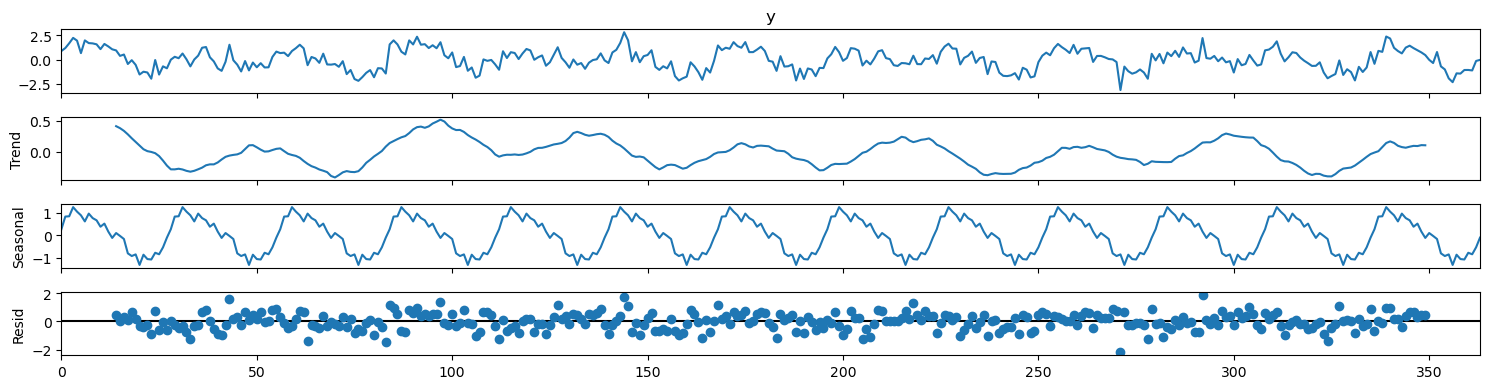

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose 
a = seasonal_decompose(df["y"], model = "additive", period=28)
a.plot();

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plotSeasonalDecompose(
    x,
    model='additive',
    filt=None,
    period=None,
    two_sided=True,
    extrapolate_trend=0,
    title="Seasonal Decomposition"):

    result = seasonal_decompose(
            x, model=model, filt=filt, period=period,
            two_sided=two_sided, extrapolate_trend=extrapolate_trend)
    fig = make_subplots(
            rows=4, cols=1,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"])
    for idx, col in enumerate(['observed', 'trend', 'seasonal', 'resid']):
        fig.add_trace(
            go.Scatter(x=result.observed.index, y=getattr(result, col), mode='lines'),
                row=idx+1, col=1,
            )
    return fig

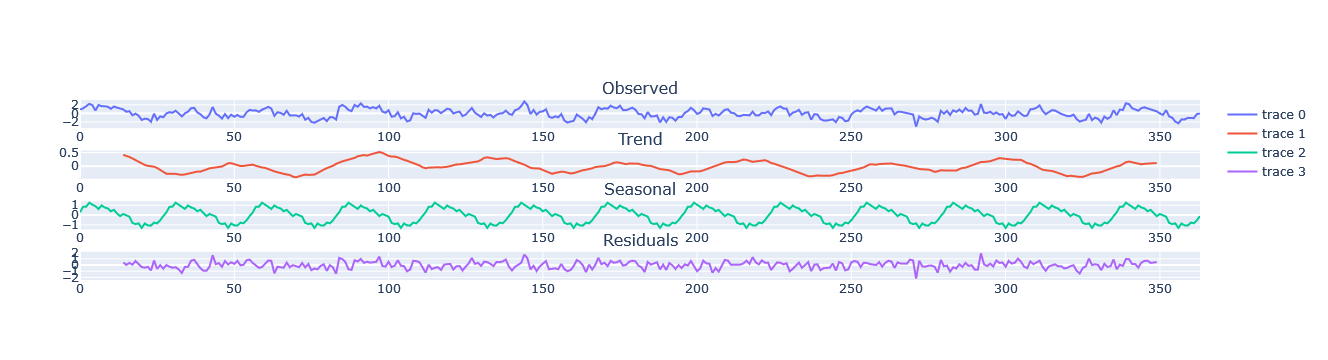

In [ ]:
plotSeasonalDecompose(
    df["y"],
    model="additive",
    period=28,
    title="Seasonal Decomposition")

## Create Model

In [ ]:
horizon = 28 * 2

train_size = weeks * resolution - horizon
train, test = df[:train_size], df[train_size:]


df.shape, train.shape, test.shape

((364, 3), (308, 3), (56, 3))

In [ ]:
from neuralforecast import models
models.__all__

['RNN',
 'GRU',
 'LSTM',
 'TCN',
 'DeepAR',
 'DilatedRNN',
 'MLP',
 'NHITS',
 'NBEATS',
 'NBEATSx',
 'TFT',
 'VanillaTransformer',
 'Informer',
 'Autoformer',
 'PatchTST',
 'FEDformer',
 'StemGNN',
 'HINT',
 'TimesNet']

In [ ]:
from ray import tune

from neuralforecast.core import NeuralForecast
from neuralforecast.auto import AutoMLP
from neuralforecast.models import *

In [ ]:
model_list = [RNN,
 GRU,
 LSTM,
 TCN,
 #DeepAR,  # not good
 DilatedRNN,
 MLP,
 NHITS,
 NBEATS,
 NBEATSx,
 #TFT, # too much GPU
 #VanillaTransformer, # not good
 #Informer,
 #Autoformer,
 #PatchTST, # too much GPU
 FEDformer,
 #StemGNN, #need n_series
 #HINT, #need n_series
 TimesNet
             ]

In [ ]:
models = [NBEATS(input_size=2 * horizon, h=horizon, max_steps=50),
          NHITS(input_size=2 * horizon, h=horizon, max_steps=50),
          LSTM(input_size=2 * horizon, h=horizon, max_steps=50),
          RNN(input_size=2 * horizon, h=horizon, max_steps=50),
          #DeepAR(input_size=2 * horizon, h=horizon, max_steps=50),
          ]
models

Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1


[NBEATS, NHITS, LSTM, RNN]

In [ ]:
models = [model(input_size=2 * horizon, h=horizon, max_steps=50) for model in model_list]
models

Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1


[RNN,
 GRU,
 LSTM,
 TCN,
 DilatedRNN,
 MLP,
 NHITS,
 NBEATS,
 NBEATSx,
 FEDformer,
 TimesNet]

In [ ]:
nf = NeuralForecast(
    models=models, 
    freq='D')

In [ ]:
nf.fit(df=train)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
Y_hat_df = nf.predict().reset_index()
Y_hat_df.head()

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

,unique_id,ds,RNN,GRU,LSTM,TCN,DilatedRNN,MLP,NHITS,NBEATS,NBEATSx,FEDformer,TimesNet
0,1,2022-02-03,0.331584,0.631020,0.475472,-0.038207,-0.242601,0.502359,0.265126,0.453357,0.453357,-0.182627,0.269210
1,1,2022-02-04,0.583147,0.764406,0.713646,0.352403,0.103927,0.741343,0.922827,0.823710,0.823710,-0.162300,0.336149
2,1,2022-02-05,0.765167,0.928452,0.901598,0.561872,0.427954,1.571360,1.317898,1.327817,1.327817,-0.034034,0.661099
3,1,2022-02-06,1.032644,1.010103,1.000895,0.721533,0.633509,1.472482,1.339687,1.358186,1.358186,0.034521,0.637762
4,1,2022-02-07,1.117871,0.940542,1.053691,0.720811,0.799598,0.619373,0.754560,0.555699,0.555699,0.285614,0.453590


In [ ]:
import altair as alt

def long_form(df_plot):
    return df_plot.melt('ds', var_name='unique_id', value_name='price')

def altair_plot(df_plot): 
    highlight = alt.selection_point(on='mouseover', fields=['unique_id'], nearest=True)

    base = alt.Chart(df_plot).encode(
        x='ds:T',
        y='price:Q',
        color='unique_id:N'
    )

    points = base.mark_circle().encode(
        opacity=alt.value(0)
    ).add_params(
        highlight
    ).properties(
        width=1000
    )

    lines = base.mark_line().encode(
        size=alt.condition(~highlight, alt.value(1), alt.value(3))
    )

    return points + lines

In [ ]:
df_test = df_plot.query("unique_id == 'final'")[int(-horizon*1.5):]
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84 entries, 280 to 363
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         84 non-null     datetime64[ns]
 1   unique_id  84 non-null     object        
 2   price      84 non-null     object        
dtypes: datetime64[ns](1), object(2)
memory usage: 2.6+ KB


In [ ]:
Y_hat_df_plot = long_form(Y_hat_df)
Y_hat_df_plot = pd.concat([Y_hat_df_plot, df_test])
Y_hat_df_plot

,ds,unique_id,price
0,2022-02-03,unique_id,1.0
1,2022-02-04,unique_id,1.0
2,2022-02-05,unique_id,1.0
3,2022-02-06,unique_id,1.0
4,2022-02-07,unique_id,1.0
...,...,...,...
359,2022-03-26,final,-1.075326
360,2022-03-27,final,-1.071706
361,2022-03-28,final,-1.120472
362,2022-03-29,final,-0.144448


In [ ]:
altair_plot(Y_hat_df_plot)

alt.LayerChart(...)

## Cross_Validate

In [ ]:
cv_df = nf.cross_validation(train,
                            n_windows=3,
                            step_size= 1,
                           )

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
cv_df

,unique_id,ds,cutoff,RNN,GRU,LSTM,TCN,DilatedRNN,MLP,NHITS,NBEATS,NBEATSx,FEDformer,TimesNet,y
0,1,2021-12-07,2021-12-06,-0.778345,-0.969260,-0.483473,-0.407675,-0.524945,-0.242061,-0.833775,-0.968383,-0.968383,-0.462379,-0.700719,-0.267128
1,1,2021-12-08,2021-12-06,-0.359986,-0.682918,-0.116346,0.194638,-0.258169,0.580216,-0.103585,-0.040710,-0.040710,-0.272619,-0.120367,0.398125
2,1,2021-12-09,2021-12-06,0.080185,-0.489487,0.189207,0.893661,0.122502,0.703065,0.251461,0.202799,0.202799,-0.386625,0.650040,0.713358
3,1,2021-12-10,2021-12-06,0.420153,-0.168859,0.588188,1.055157,0.567973,0.423164,0.301031,-0.088764,-0.088764,-0.223006,0.892449,0.444308
4,1,2021-12-11,2021-12-06,0.609588,0.150088,0.860370,1.401579,0.843187,1.076406,0.479369,0.147314,0.147314,0.004845,1.196441,1.166163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1,2022-01-29,2021-12-08,-0.816204,-0.884289,-0.871417,-0.255213,-0.707452,-0.492719,-0.523672,-0.679037,-0.679037,-0.484612,-1.257144,-0.454238
164,1,2022-01-30,2021-12-08,-0.537164,-0.846854,-0.757211,-0.179368,-0.697815,0.400379,-0.333994,-0.465267,-0.465267,-0.101902,-0.588163,0.476971
165,1,2022-01-31,2021-12-08,-0.216456,-0.549389,-0.587268,0.079020,-0.561862,-0.253625,-0.154823,-0.330897,-0.330897,-0.321723,-0.174761,-0.097651
166,1,2022-02-01,2021-12-08,-0.128435,-0.410667,-0.445573,0.186666,-0.337242,-0.443354,-0.162674,-0.416916,-0.416916,-0.184451,-0.204958,-0.622777


In [ ]:
cv_df.drop('cutoff', axis=1, inplace=True)
cv_df.drop('unique_id', axis=1, inplace=True)

In [ ]:
cv_df = long_form(cv_df)

In [ ]:
cv_df

,ds,unique_id,price
0,2021-12-07,RNN,-0.778345
1,2021-12-08,RNN,-0.359986
2,2021-12-09,RNN,0.080185
3,2021-12-10,RNN,0.420153
4,2021-12-11,RNN,0.609588
...,...,...,...
2011,2022-01-29,y,-0.454238
2012,2022-01-30,y,0.476971
2013,2022-01-31,y,-0.097651
2014,2022-02-01,y,-0.622777


In [ ]:
altair_plot(cv_df)

alt.LayerChart(...)

## Performance

In [ ]:
from datasetsforecast.losses import (mae, mape, mase, rmse, smape)

In [ ]:
Y_hat_df.info(), Y_hat_df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   unique_id   56 non-null     int64         
 1   ds          56 non-null     datetime64[ns]
 2   RNN         56 non-null     float64       
 3   GRU         56 non-null     float64       
 4   LSTM        56 non-null     float64       
 5   TCN         56 non-null     float64       
 6   DilatedRNN  56 non-null     float64       
 7   MLP         56 non-null     float64       
 8   NHITS       56 non-null     float64       
 9   NBEATS      56 non-null     float64       
 10  NBEATSx     56 non-null     float64       
 11  FEDformer   56 non-null     float64       
 12  TimesNet    56 non-null     float64       
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usage: 5.8 KB


(None,
 Index(['unique_id', 'ds', 'RNN', 'GRU', 'LSTM', 'TCN', 'DilatedRNN', 'MLP',
        'NHITS', 'NBEATS', 'NBEATSx', 'FEDformer', 'TimesNet'],
       dtype='object'))

In [ ]:
def evaluate_performace(y_hist, y_true, y_pred):
    #y_true = y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
    evaluation = {}
    print(y_pred.columns)
    for i, model in enumerate(y_pred.columns):
        if i < 2: continue
        evaluation[model] = {}
        for metric in [mase, mae, mape, rmse, smape]:
            metric_name = metric.__name__
            if metric_name == 'mase':
                evaluation[model][metric_name] = metric(y_true['y'].values, 
                                                    y_pred[model].values, 
                                                    y_hist['y'].values, seasonality=12)
            else:
                evaluation[model][metric_name] = metric(y_true['y'].values, y_pred[model].values)
    return pd.DataFrame(evaluation)

In [ ]:
train.columns, test.columns, Y_hat_df.columns

(Index(['y', 'unique_id', 'ds'], dtype='object'),
 Index(['y', 'unique_id', 'ds'], dtype='object'),
 Index(['unique_id', 'ds', 'RNN', 'GRU', 'LSTM', 'TCN', 'DilatedRNN', 'MLP',
        'NHITS', 'NBEATS', 'NBEATSx', 'FEDformer', 'TimesNet'],
       dtype='object'))

In [ ]:
evaluate_performace(train, test, Y_hat_df).style.background_gradient(cmap ='YlGn', axis = 1,low=0.5, high=0.6)

Index(['unique_id', 'ds', 'RNN', 'GRU', 'LSTM', 'TCN', 'DilatedRNN', 'MLP',
       'NHITS', 'NBEATS', 'NBEATSx', 'FEDformer', 'TimesNet'],
      dtype='object')


,RNN,GRU,LSTM,TCN,DilatedRNN,MLP,NHITS,NBEATS,NBEATSx,FEDformer,TimesNet
mase,0.435034,0.415272,0.433738,0.399972,0.522614,0.281610,0.282663,0.263021,0.263021,0.499493,0.369554
mae,0.623615,0.595287,0.621757,0.573353,0.749160,0.403684,0.405194,0.377037,0.377037,0.716016,0.529751
mape,113.600705,107.218164,125.201220,122.939644,122.842224,94.040212,96.869127,92.912373,92.912373,138.528635,124.077713
rmse,0.748148,0.719231,0.734778,0.697955,0.884842,0.509274,0.512601,0.496020,0.496020,0.869066,0.658590
smape,95.296856,88.066236,94.181277,92.506326,105.355498,63.243037,61.651949,62.291407,62.291407,110.947770,73.907614


In [ ]:
results = evaluate_performace(train, test, Y_hat_df)
results.to_csv('Data/Neutral_results2.csv')

Index(['unique_id', 'ds', 'RNN', 'GRU', 'LSTM', 'TCN', 'DilatedRNN', 'MLP',
       'NHITS', 'NBEATS', 'NBEATSx', 'FEDformer', 'TimesNet'],
      dtype='object')
